# *

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import copy 

In [66]:
def show(*args, c=2) -> None: 
    l = len(args)
    if l > 4:
        raise Exception("To many images were provide")
    r = max(round(l/c), 1)
    fig = plt.figure(figsize=(20, 15))
    for i, data in enumerate(args):
        pos = i+1
        ax = fig.add_subplot(r, c, pos)
        img_has_name = type(data) == tuple
        if img_has_name:
            img = data[0]
            name = data[1]
            ax.title.set_text(name)
        else: img = data
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img[:, :, ::-1])
        plt.axis("off")

    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.show()

def normalize(img, alpha=0, beta=1):
    return cv2.normalize(img, None, alpha=alpha, beta=beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def cvt_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Lucas Kanade Optic Flow

<i>`In this part, you need to implement the basic LK step.` <br>
`You need to write a code to create gradient images and implement the Lucas and Kanade optic flow algorithm.`</i>

In [67]:
shift_0 = cvt_gray(cv2.imread('./input/TestSeq/Shift0.png'))
shift_r2 = cvt_gray(cv2.imread('./input/TestSeq/ShiftR2.png'))
shift_r5u5 = cvt_gray(cv2.imread('./input/TestSeq/ShiftR5U5.png'))
shift_r10 = cvt_gray(cv2.imread('./input/TestSeq/ShiftR10.png'))
shift_r20 = cvt_gray(cv2.imread('./input/TestSeq/ShiftR20.png'))
shift_r40 = cvt_gray(cv2.imread('./input/TestSeq/ShiftR40.png'))

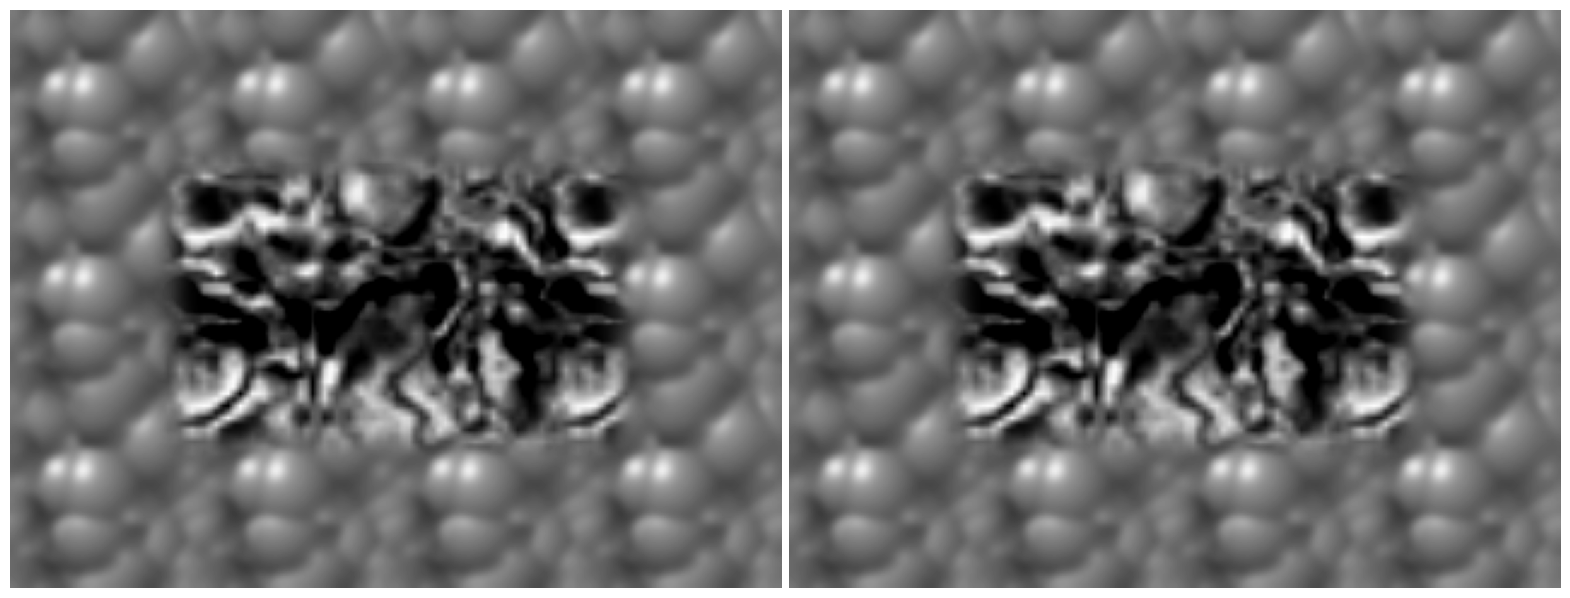

In [68]:
show(shift_0, shift_r2)

In [69]:
def xderivative(img, ksize=7)->np.ndarray:
    return cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)

def yderivative(img, ksize=7)->np.ndarray:
    return cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)

def tderivative(img1, img2)->np.ndarray:
    return img2.astype(np.float32)-img1.astype(np.float32)

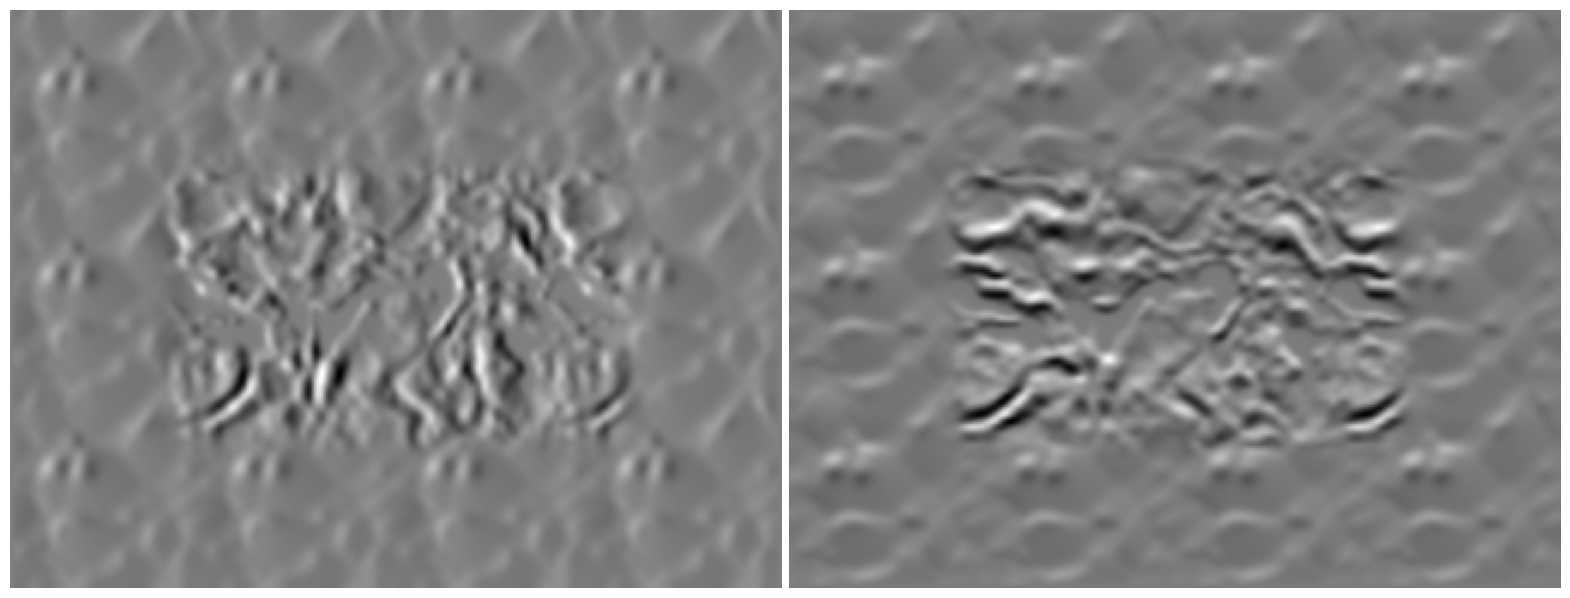

In [70]:
show(normalize(xderivative(shift_0)), normalize(yderivative(shift_0)))

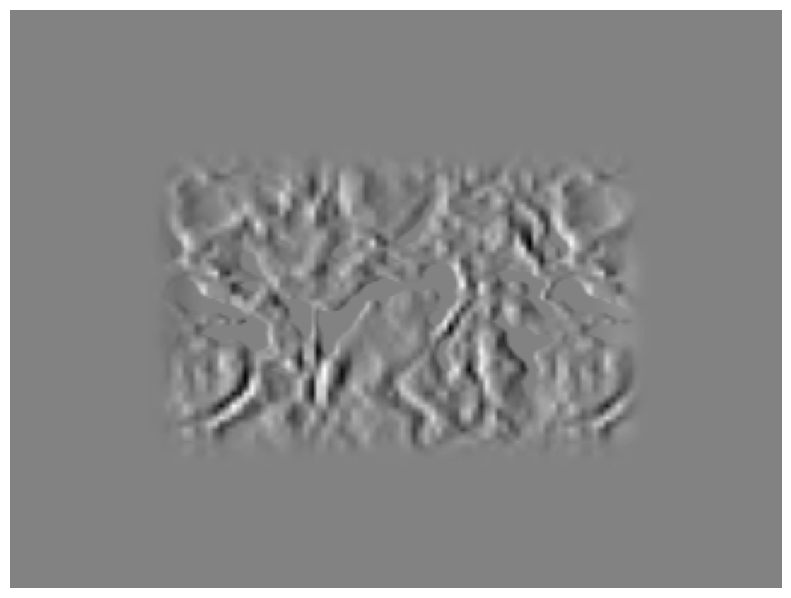

In [71]:
show(normalize(tderivative(shift_r2, shift_0)))

In [72]:
def get_gaussian_kernel(size=5, sigma=0):    
    g_kernel = cv2.getGaussianKernel(size, sigma)
    return np.dot(g_kernel, g_kernel.T)

In [73]:
def weighted_sum(*args, ksize=15, sigma=0):
    g_kernel = get_gaussian_kernel(ksize, sigma)
    wsums = tuple()
    for arg in args:
        wsums += (cv2.filter2D(arg, -1, g_kernel), )
    return wsums

In [74]:
def lk_step(img1, img2, window=None)->np.ndarray:
    if window is None:
        window = max(min(min(img1.shape[0], img1.shape[1])/4, 45), 3)
        window = int(window) + 1
    Ix, Iy, It = xderivative(img1), yderivative(img1), tderivative(img1, img2)
    wxx, wyy, wxy, wxt, wyt = weighted_sum(Ix*Ix, Iy*Iy, Ix*Iy, Ix*It, Iy*It, ksize=window)
    del Ix, Iy, It
    h, w = wxx.shape
    u = np.zeros((h, w), dtype=np.float32)
    v = np.zeros((h, w), dtype=np.float32)
    for y in range(h):
        for x in range(w):
            A = np.array([[wxx[y, x], wxy[y, x]],
                          [wxy[y, x], wyy[y, x]]])
            if (np.linalg.det(A) - 0.05*(np.trace(A)**2)) < 0.2:
                continue
            b = np.array([-wxt[y, x], -wyt[y, x]]).T
            displacement_vector = np.linalg.lstsq(A, b, rcond=None)[0]
            u[y, x] = displacement_vector[0]
            v[y, x] = displacement_vector[1]
    return u, v


In [75]:
def draw_displacements(img, u, v, w=5, d_scale=25e2, img_scale=10, thickness=5)->np.ndarray:
    img = copy(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    ctr = w // 2 
    resized = cv2.resize(img, (img.shape[1]*img_scale, img.shape[0]*img_scale), interpolation=cv2.INTER_AREA)
    for y in range(ctr, img.shape[0] - ctr, w):
        for x in range(ctr, img.shape[1]- ctr, w):
            disp_u = u[y, x]*d_scale
            disp_v = v[y, x]*d_scale
            if disp_v == 0 and disp_u == 0:
                continue
            start_point = (x*img_scale, y*img_scale)
            end_point = (round(x + disp_u)*img_scale, round(y + disp_v)*img_scale)
            cv2.arrowedLine(resized, start_point, end_point, color=(255, 255, 0), thickness=thickness, line_type=cv2.LINE_8, tipLength=0.5)
    return resized

## different displacements depending on window size

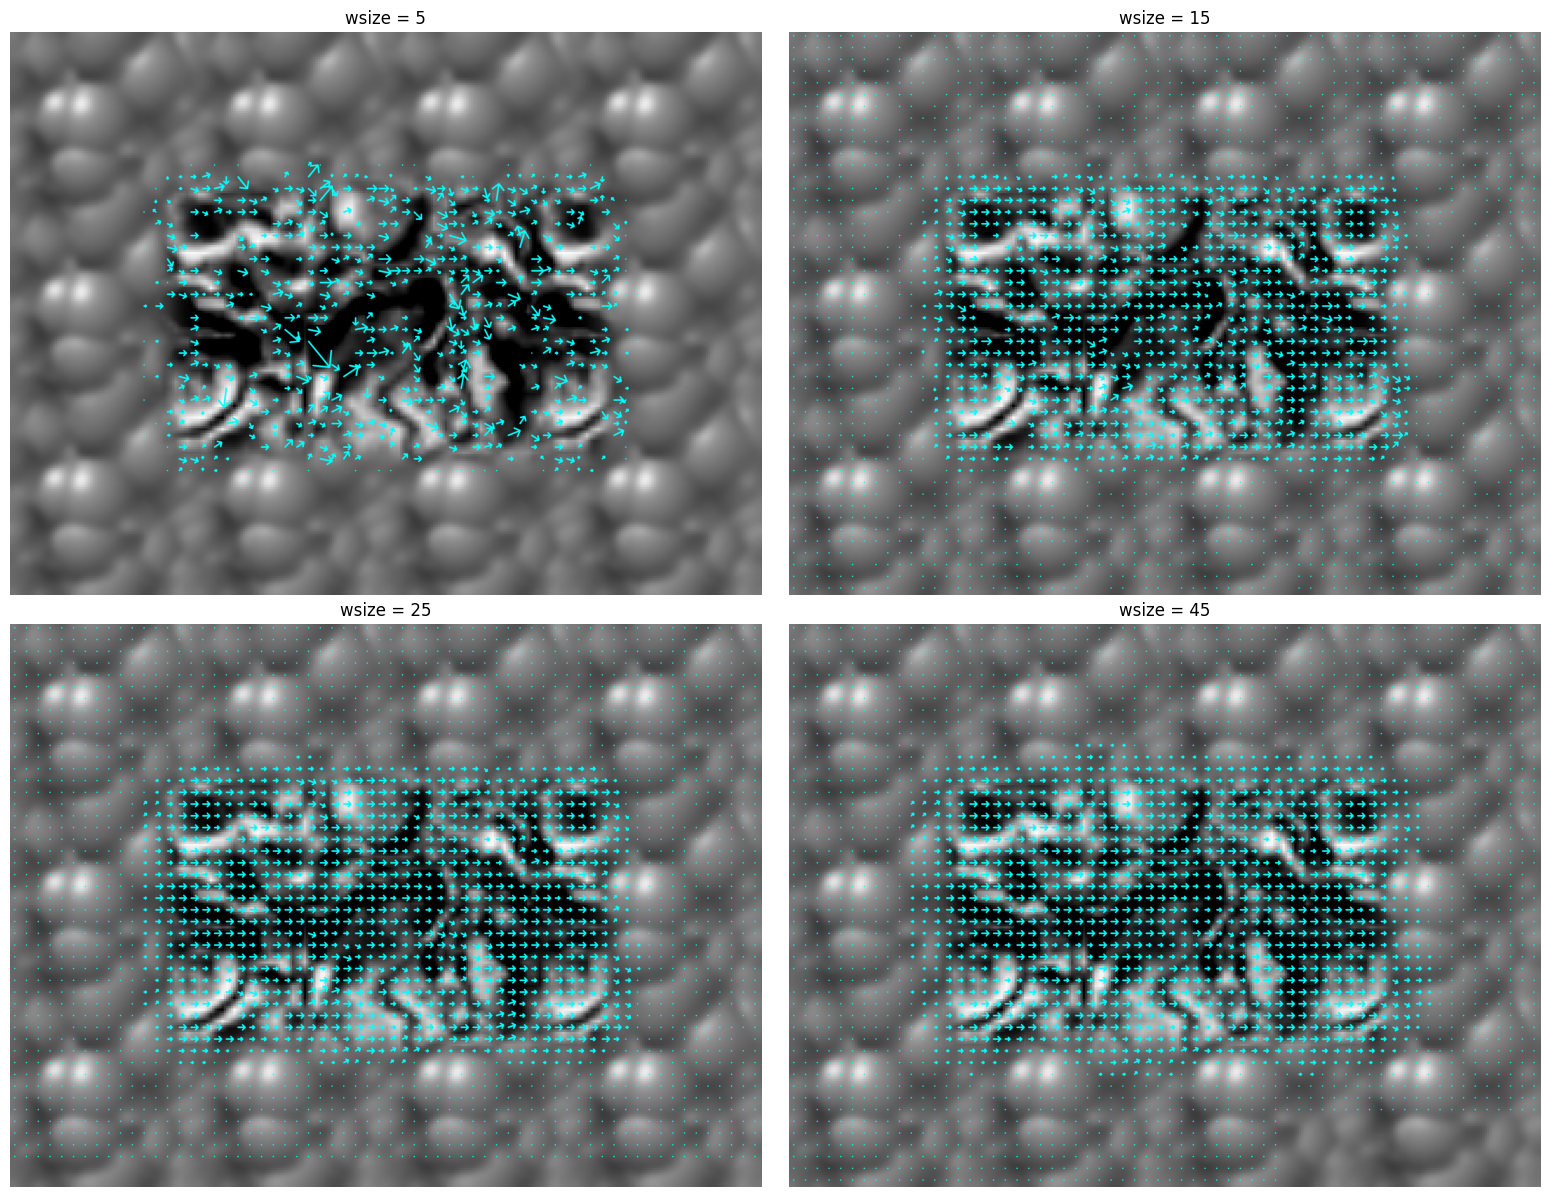

In [76]:
u1, v1 = lk_step(shift_0, shift_r2, window=5)
displacement_img_1 = draw_displacements(shift_0, u1, v1)
u2, v2 = lk_step(shift_0, shift_r2, window=15)
displacement_img_2 = draw_displacements(shift_0, u2, v2)
u3, v3 = lk_step(shift_0, shift_r2, window=25)
displacement_img_3 = draw_displacements(shift_0, u3, v3)
u4, v4 = lk_step(shift_0, shift_r2, window=45)
displacement_img_4 = draw_displacements(shift_0, u4, v4)
show((displacement_img_1, "wsize = 5"), (displacement_img_2, "wsize = 15"), (displacement_img_3, "wsize = 25"), (displacement_img_4, "wsize = 45"))

## other images displacements

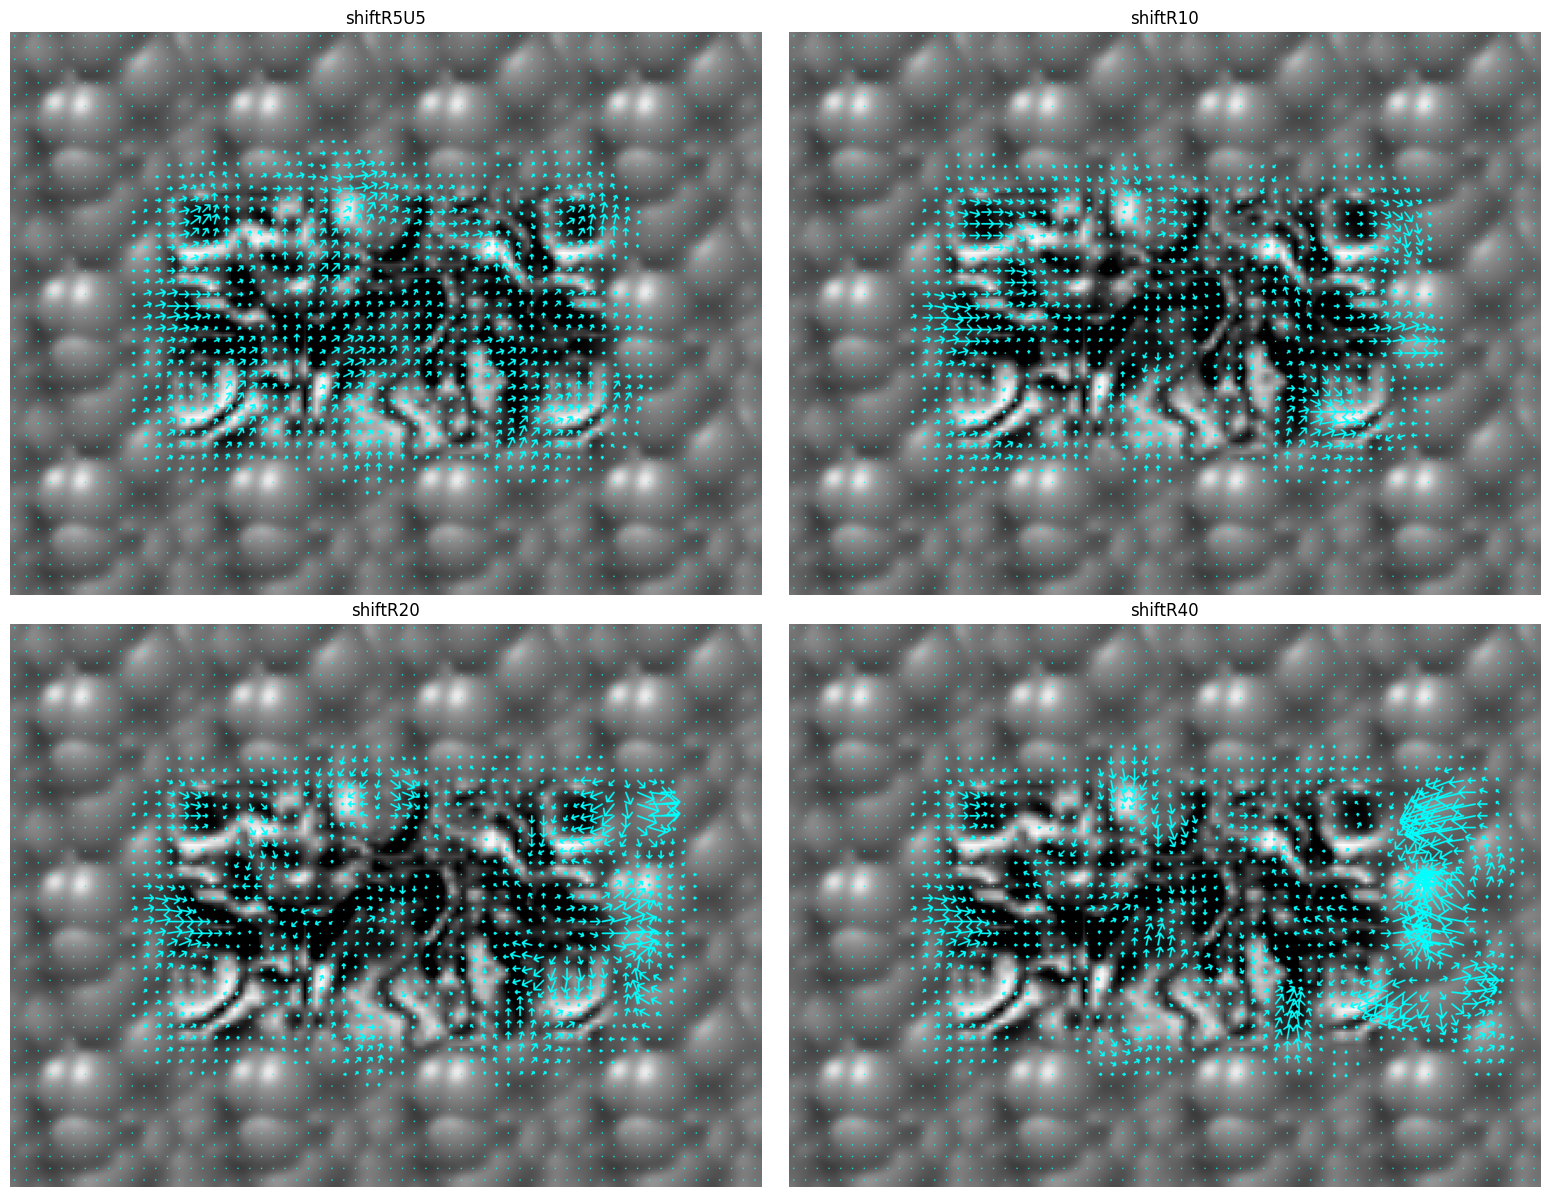

In [77]:
u1, v1 = lk_step(shift_0, shift_r5u5)
displacement_img_1 = draw_displacements(shift_0, u1, v1)
u2, v2= lk_step(shift_0, shift_r10)
displacement_img_2 = draw_displacements(shift_0, u2, v2)
u3, v3 = lk_step(shift_0, shift_r20)
displacement_img_3 = draw_displacements(shift_0, u3, v3)
u4, v4 = lk_step(shift_0, shift_r40)
displacement_img_4 = draw_displacements(shift_0, u4, v4)
show((displacement_img_1, "shiftR5U5"), (displacement_img_2, "shiftR10"), (displacement_img_3, "shiftR20"), (displacement_img_4, "shiftR40"))

# Gaussian and Laplacian Pyramids<br>

<i>`In lectures we described the Gaussian pyramid constructed using the REDUCE operator.`<br>
`Write a function to implement REDUCE.`

In [78]:
def reduce(img):
    im_blur = cv2.GaussianBlur(img, (5, 5), 0)
    return im_blur[::2, ::2]

In [79]:
def gaussian_pyramid(img, level=3):
    pyramid = [img]
    [pyramid.append(reduce(pyramid[i])) for i in range(level)]
    return pyramid

In [80]:
yos_1 = cvt_gray(cv2.imread('./input/DataSeq1/yos_img_01.jpg'))
yos_2 = cvt_gray(cv2.imread('./input/DataSeq1/yos_img_02.jpg'))
yos_3 = cvt_gray(cv2.imread('./input/DataSeq1/yos_img_03.jpg'))

<i>`Use this to produce a Gaussian Pyramid of 4 levels (0-3). Demonstrate using the first frame of the DataSeq1 sequence.`

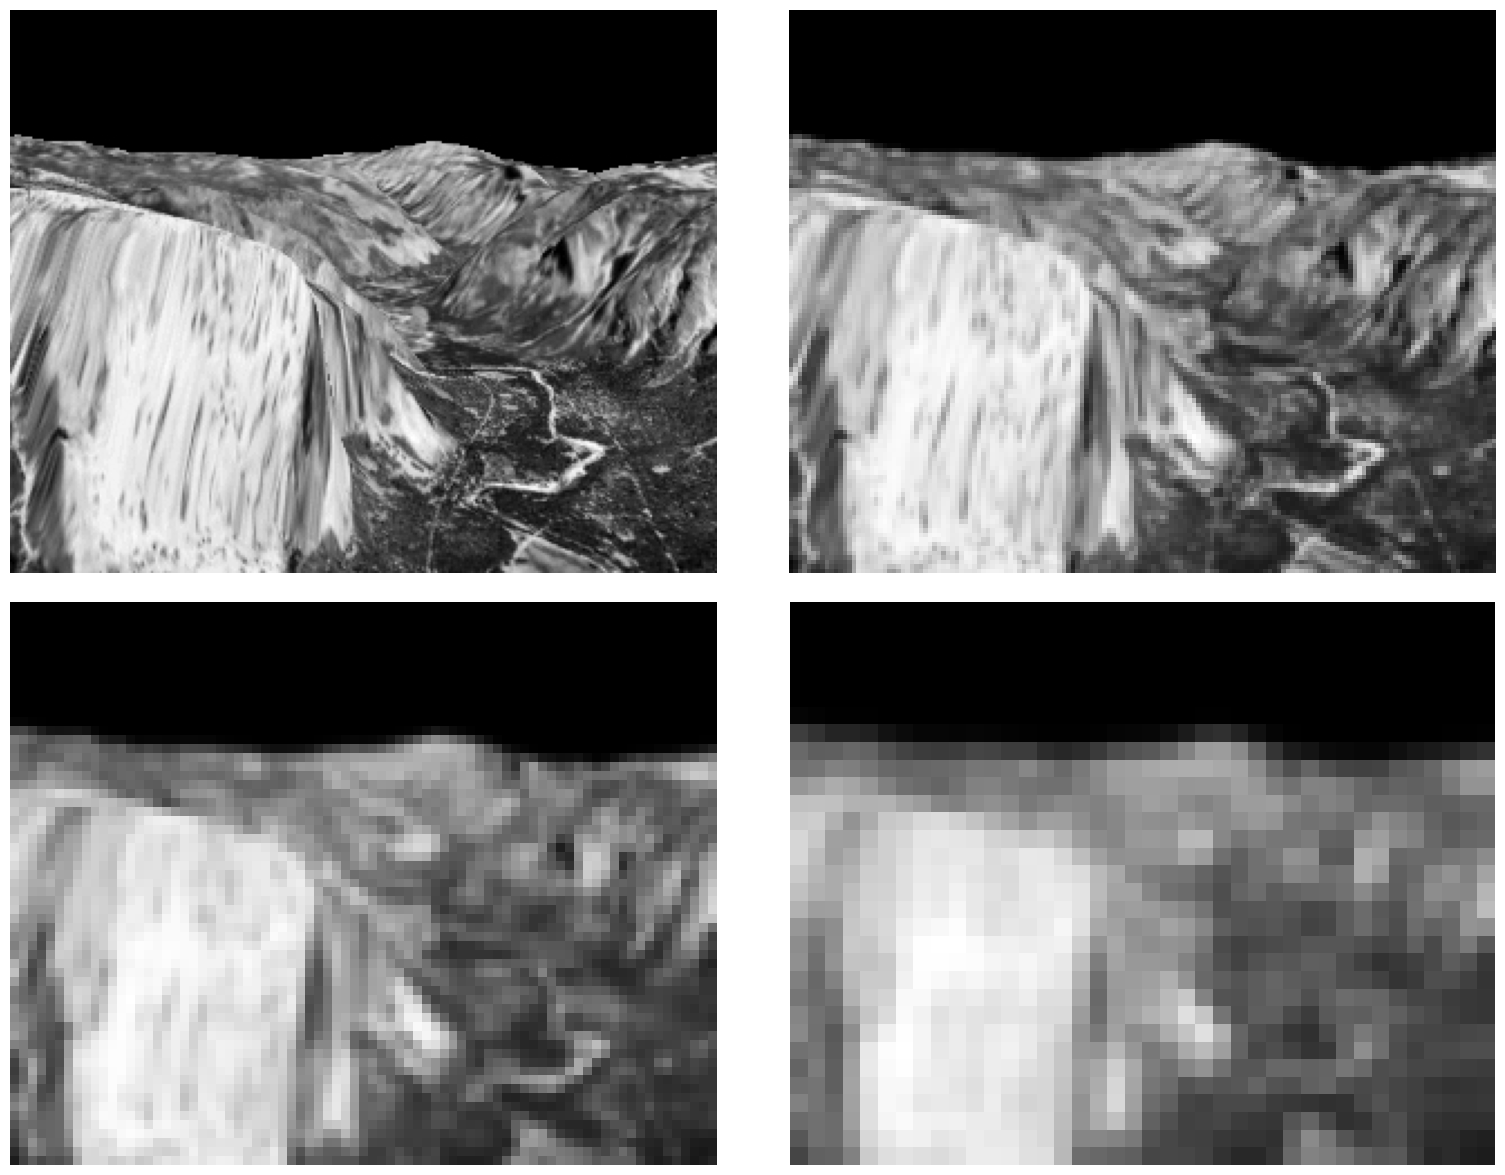

In [81]:
show(*gaussian_pyramid(yos_1))

<i>`Although the Lucas and Kanade method does not use the Laplacian Pyramid, you do need to expand the warped coarser levels.`<br>
`Therefore you will need to implement the EXPAND operator.`

In [82]:
def expand(img):
    shape = (img.shape[0]*2-1, img.shape[1]*2-1)
    expanded = np.zeros(shape, dtype=np.float32)
    expanded[::2, ::2] = img
    for i in range(0, expanded.shape[0], 2):
        for j in range(1, expanded.shape[1], 2):
            expanded[i, j] = 0.5*expanded[i, j-1] + 0.5*expanded[i, j+1]
    for i in range(1, expanded.shape[0], 2):
        for j in range(0, expanded.shape[1]):
            expanded[i, j] = 0.5*expanded[i-1, j] + 0.5*expanded[i+1, j]
    return expanded

In [83]:
def laplacian_pyramid(img, level=3):
    g_p = gaussian_pyramid(img, level)
    l_p = [g_p[-1]]
    for i in range(len(g_p)-2, -1, -1):
        exp = expand(g_p[i + 1])
        if exp.shape[0] < g_p[i].shape[0]:
            exp = np.r_[exp, exp[-1, :].reshape(1, -1)]
        if exp.shape[1] < g_p[i].shape[1]:
            exp = np.c_[exp, exp[:, -1]]
        l_i = g_p[i] - exp 
        l_p.append(l_i)
    return l_p

<i>`Write the function EXPAND. Using it and the above REDUCE, create the 4 level Laplacian pyramid of DataSeq1 (which has 1 Gaussian image and the 3 Laplacian images).`

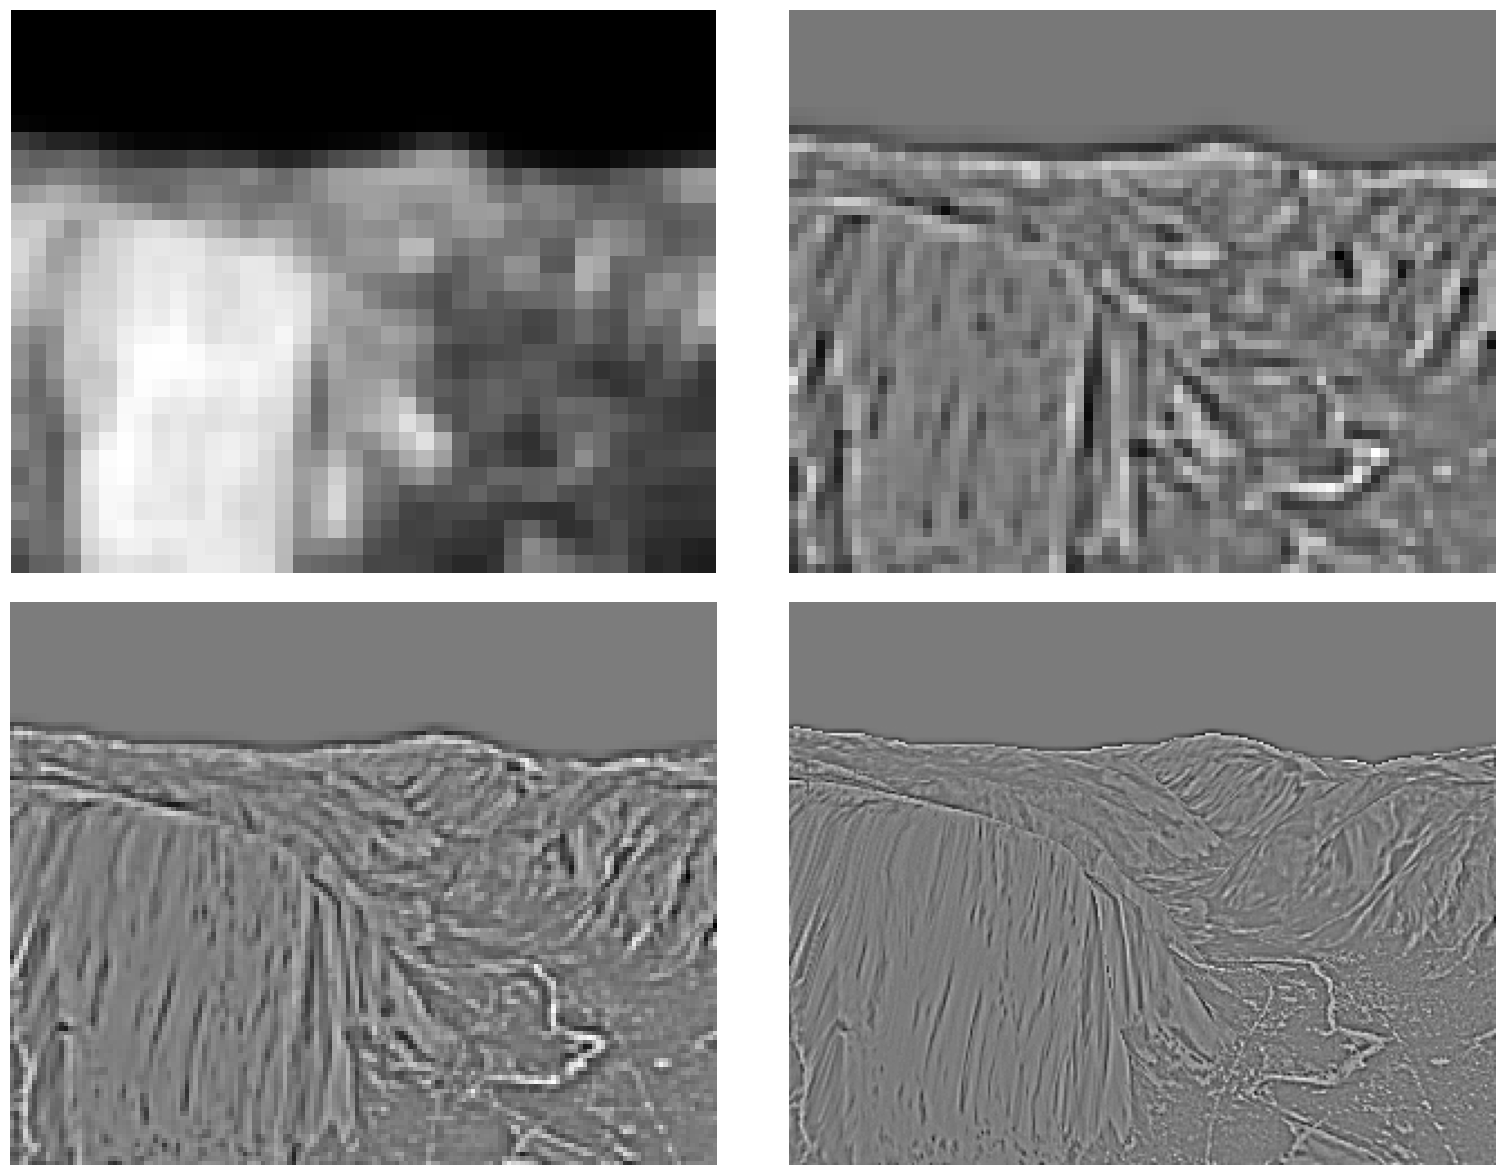

In [84]:
l_p = laplacian_pyramid(yos_1, level=3)
show(*l_p)

# Warping by flow
 

In [85]:
def remap(img, u, v, scale=1):
    ys = np.tile(np.arange(img.shape[0], dtype=np.float32).reshape(-1, 1), (1, img.shape[1]))+v*scale
    xs = np.tile(np.arange(img.shape[1], dtype=np.float32), (img.shape[0], 1))+u*scale
    ys = np.clip(ys, 0, ys.shape[0]-1)
    xs = np.clip(xs, 0, xs.shape[1]-1)
    r = cv2.remap(img, xs, ys, interpolation=cv2.INTER_LINEAR)
    return r

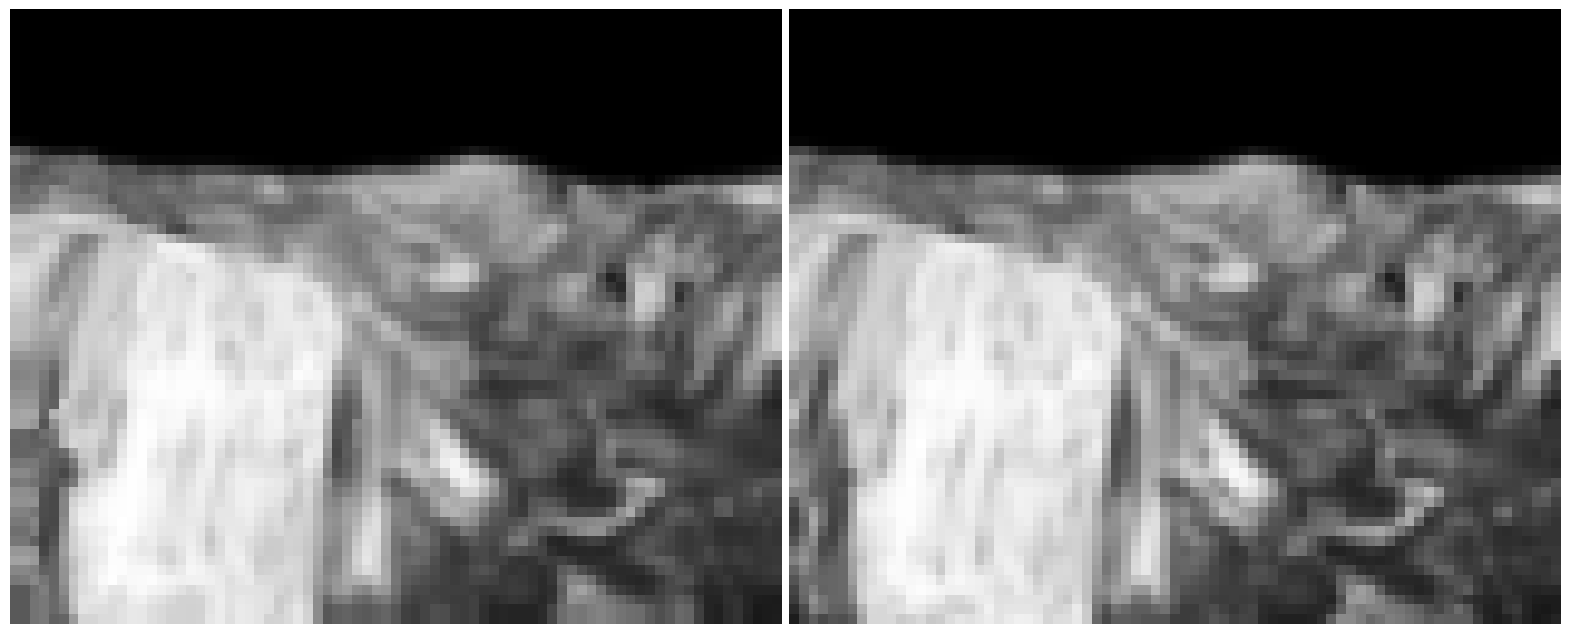

In [86]:
l = 2
gp_y1 = gaussian_pyramid(yos_1)[2]
gp_y2 = gaussian_pyramid(yos_2)[2]
u, v  = lk_step(gp_y1, gp_y2, 15)
r2 = remap(gp_y2, u, v, 2500)
show(r2, gp_y1)

# Hierarchical LK optic flow

<i>`Write the function to compute the hierarchical LK. `

In [87]:
def hlk(img1, img2, level=4, window=None):
    img1_gp = gaussian_pyramid(img1, level)[::-1]
    img2_gp = gaussian_pyramid(img2, level)[::-1]
    shape = (img1_gp[0].shape[0], img1_gp[0].shape[1])
    u = np.zeros(shape, dtype=np.float32)
    v = np.zeros(shape, dtype=np.float32)
    k = level + 1
    for im1, im2 in zip(img1_gp, img2_gp):
        if im2.shape[0] != u.shape[0]:
            u = np.pad(u, [(0, 1), (0, 0)])
            v = np.pad(v, [(0, 1), (0, 0)])
        if im2.shape[1] != u.shape[1]:
            u = np.pad(u, [(0, 0), (0, 1)])
            v = np.pad(v, [(0, 0), (0, 1)])
        im2 = remap(im2, u, v)
        u_tmp, v_tmp = lk_step(im1, im2, window=window)
        u += u_tmp
        v += v_tmp
        k -= 1
        if k > 0:
            u = 2 * expand(u)
            v = 2 * expand(v)
    return u, v

In [88]:
i0 = cvt_gray(cv2.imread('./input/DataSeq2/0.png'))
i1 = cvt_gray(cv2.imread('./input/DataSeq2/1.png'))
i2 = cvt_gray(cv2.imread('./input/DataSeq2/2.png'))

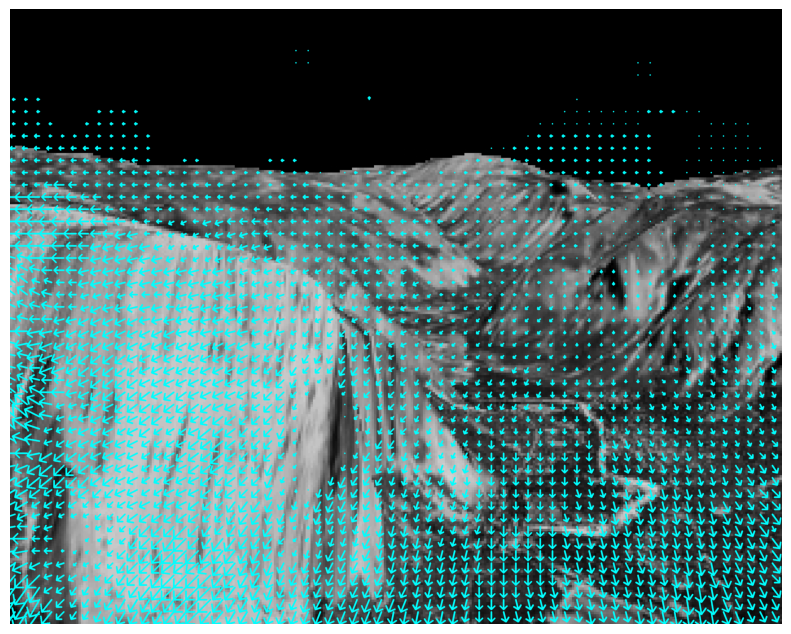

In [89]:
u, v = hlk(yos_1, yos_2, 2)
d = draw_displacements(yos_1, u, v, w=5, d_scale=1000)
show(d)

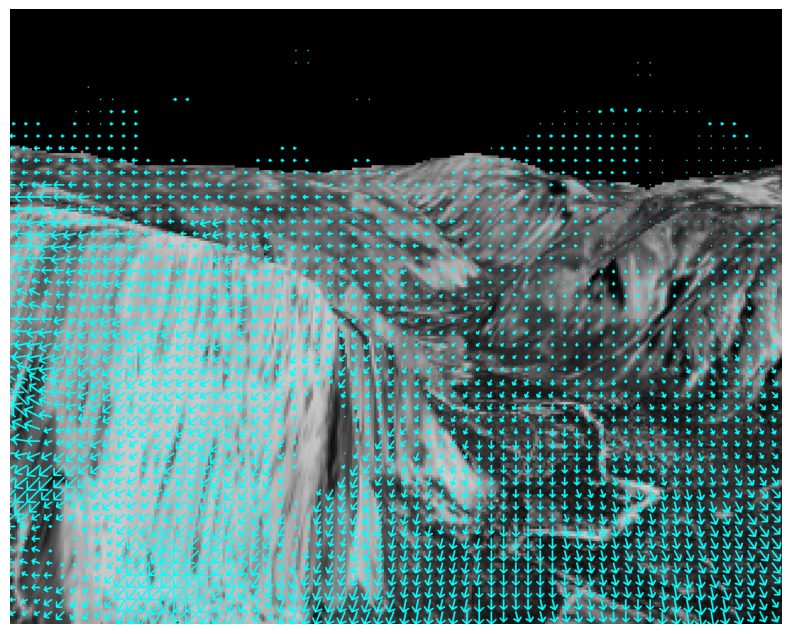

In [90]:
u, v = hlk(yos_2, yos_3, 2)
d = draw_displacements(yos_2, u, v, w=5, d_scale=1000)
show(d)

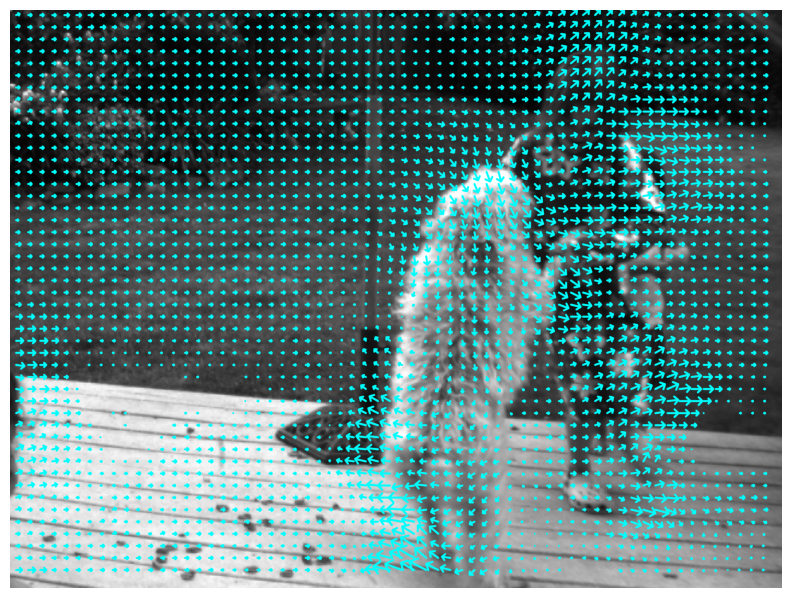

In [91]:
u, v = hlk(i0, i1, level=2)
d = draw_displacements(i0, u, v, w=10, thickness=15, d_scale=1000)
show(d)

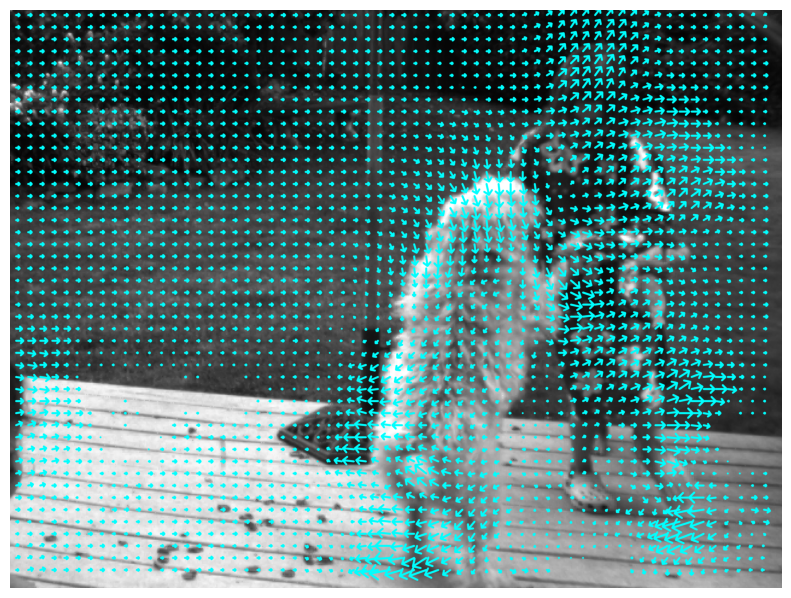

In [92]:
u, v = hlk(i1, i2, level=2)
d = draw_displacements(i1, u, v, w=10, thickness=15, d_scale=1000)
show(d)

In [93]:
juggle0 = cvt_gray(cv2.imread('./input/Juggle/0.png'))
juggle1 = cvt_gray(cv2.imread('./input/Juggle/1.png'))
juggle2 = cvt_gray(cv2.imread('./input/Juggle/2.png'))

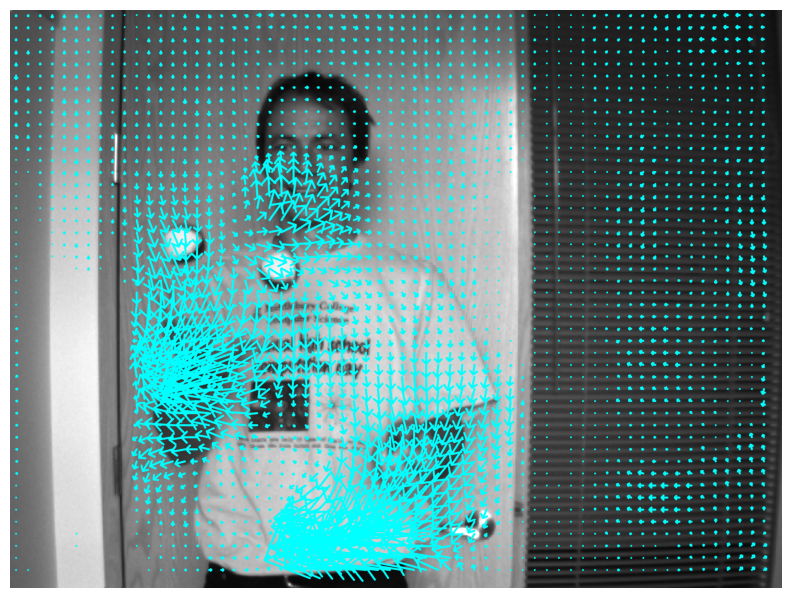

In [94]:
u, v = hlk(juggle0, juggle1, level=4)
d = draw_displacements(juggle0, u, v, w=10, thickness=15, d_scale=1000)
show(d)

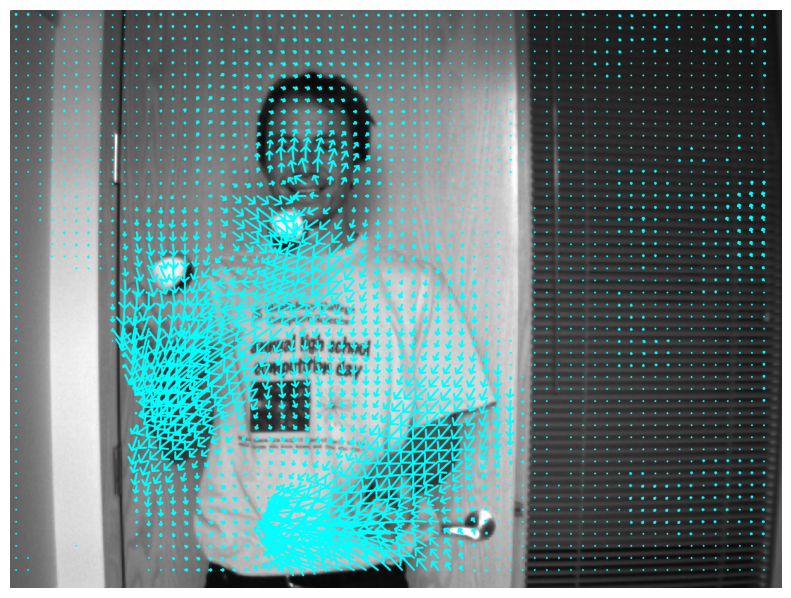

In [95]:
u, v = hlk(juggle1, juggle2, level=4)
d = draw_displacements(juggle1, u, v, w=10, thickness=15, d_scale=1000)
show(d)